# Grade: 100 points

# Assignment 03: Classification with Decision Trees, Ensemble Models and Neural Networks

## Instructions

Just like assignment 2, you will train various machine learning models for the binary classification task provided in the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) competition. Note: we will play loosely with the terms validation and test sets and may even use them interchangeably. This Kaggle competition has its own Test set file that you can make predications on and submit for scoring, so for us our "test" set could be viewed as a validation set.

The task is to predict whether an individual would survive the famous disaster. There are 11 input variables, and 2 output labels: **survived** or **did not survive**.

#### **Follow these steps before submitting your assignment:**

1. Complete the notebook.

2. Make sure all plots have axis labels.

3. Once the notebook is complete, `Restart` your kernel by clicking 'Kernel' > 'Restart & Run All'.

4. Fix any errors until your notebook runs without any problems.

5. Please note, a random seed of 42 needs to be set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**.

6. Make sure to reference all external code and documentation used.

*Note: you may need to install XGBoost. You can do this by running the cell below.*

In [605]:
#!pip install xgboost

In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Q1 - Data Loading and Exploration

`https://www.kaggle.com/competitions/titanic` contains data on passengers of the famous Titanic disaster. The task is to examine and predict what sorts of people were more likely to survive using data on their name, age, gender, socio-economic class, etc.

#### 1. Loading our Data
Load the train data into a pandas DataFrames. Display the first few rows **of each DataFrame** and print the shape of the dataframe.

In [607]:
#Q1.1
train = pd.read_csv("train.csv")
print("Training data shape:", train.shape)
train.head()


Training data shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 2. Checking for Null Values

Check for null values in the training data.

In [608]:
#Q1.2
nullVals = train.isnull().sum()
print(nullVals)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


#### 3. Checking the class balance
Since this is a binary classification task, class balance is extremely important. What percent of the training data belongs to each class? Is this roughly balanced?

In [609]:
#Q1.3
class_percentages = train["Survived"].value_counts(normalize=True) * 100
print(class_percentages)


Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


You should see that the classes are roughly balanced, about a 60-40 split between not surviving and surviving.

# Q2 - Feature Engineering

1. Fill missing values for Age and Fare with their respective median values, make sure to round age.

In [610]:
#Q2.1
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Fare"] = train["Fare"].fillna(train["Fare"].median())


2. Drop non-unique variables such as `PassengerId`, and irrelevant features such as `Ticket`, `Cabin`, and `Embarked`.

In [611]:
#Q2.2
train = train.drop(columns=["PassengerId", "Ticket", "Cabin", "Embarked"])

3. Combine `SibSp` and `Parch` into a single variable `Family`. Then drop `SibSp` and `Parch`.

In [612]:
#Q2.3
train["Family"] = train["SibSp"] + train["Parch"]

train = train.drop(columns=["SibSp", "Parch"])


Like Assignment 2, the `Name` column contains passengers' full names, including their titles (e.g., Mr., Mrs., Dr., Col.). Write code to **extract only the title** from each passenger's name. Standardize similar titles (e.g., Ms --> Miss, Mlle --> Miss, Mme --> Mrs), and group rare or honorific titles (e.g., Capt, Col, Dr, Sir, etc.) under a single label called "Special".

In [613]:
special_names = ['Capt','Col','Countess','Don','Dona','Dr','Jonkheer','Lady','Major','Rev','Sir']
train['Name'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Name'] = train['Name'].replace('Ms', 'Miss').replace('Mlle', 'Miss').replace('Mme', 'Mrs').replace(special_names, 'Special')

4. One-hot-encode the features `Name`, `Sex`, and `Pclass`.

In [614]:
#extract title from Name
train["Title"] = train["Name"].str.extract(r",\s*([^\.]+)\.")


common_titles = ["Mr", "Mrs", "Miss"]
train["Name"] = train["Name"].where(train["Name"].isin(["Mr", "Mrs", "Miss"]), "Special")
train = pd.get_dummies(train, columns=["Name"], prefix="Name")

train["Sex_male"] = train["Sex"] == "male"
train.drop(columns=["Sex"], inplace=True)

train["Pclass_Second"] = train["Pclass"] == 2
train["Pclass_Third"]  = train["Pclass"] == 3
train.drop(columns=["Pclass"], inplace=True)
train.drop(columns=["Title"], inplace=True)


5. Correlation Map
Visualize the correlation between variables using a heatmap. List the 3 features that are most related to a passenger's survival.

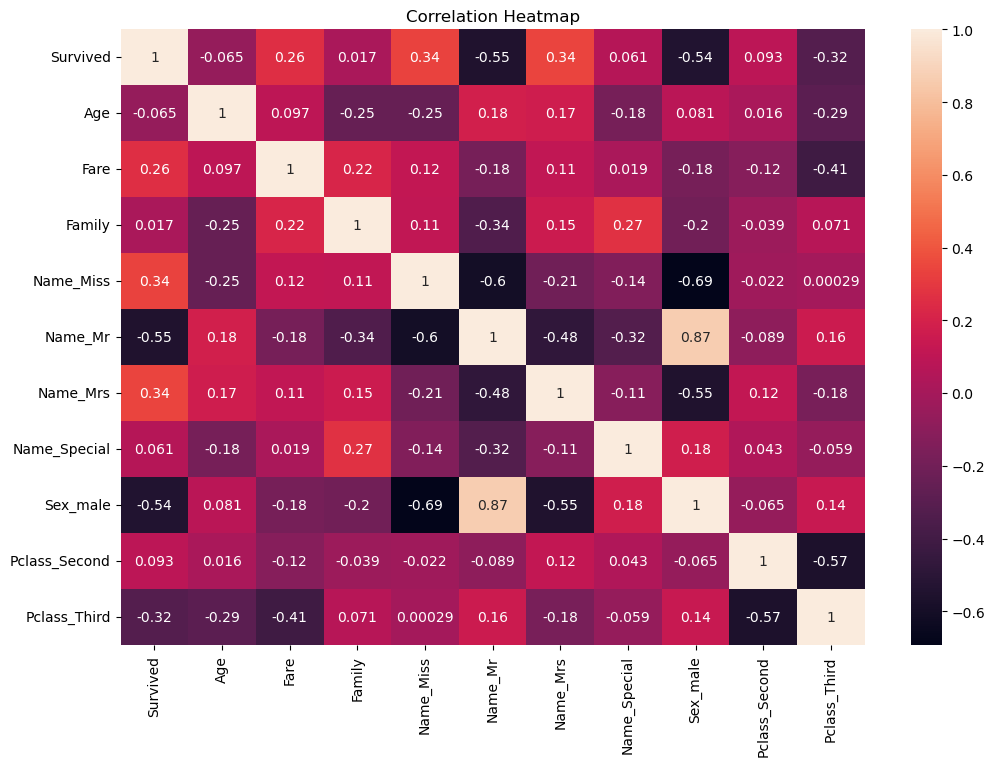

In [615]:
#Q2.5 Correlation Map
corrMatrix = train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [616]:
#Q2.5 List of three features
mostCorrelated = ["Name_Mrs", "Name_Miss", "Fare"]

### Checkpoint 1

![Checkpoint 1](checkpoint_1.png)

Your `train.head()` should look like this.

In [617]:
train.head()

,Survived,Age,Fare,Family,Name_Miss,Name_Mr,Name_Mrs,Name_Special,Sex_male,Pclass_Second,Pclass_Third
0,0,22.0,7.2500,1,False,True,False,False,True,False,True
1,1,38.0,71.2833,1,False,False,True,False,False,False,False
2,1,26.0,7.9250,0,True,False,False,False,False,False,True
3,1,35.0,53.1000,1,False,False,True,False,False,False,False
4,0,35.0,8.0500,0,False,True,False,False,True,False,True


# Q3 - Train/Test Split and Feature Scaling

#### 1. Scaling
Scale the train. Make sure you do not scale the one-hot-encoded data or the target variable (Survived).

In [618]:
train.dtypes

Survived           int64
Age              float64
Fare             float64
Family             int64
Name_Miss           bool
Name_Mr             bool
Name_Mrs            bool
Name_Special        bool
Sex_male            bool
Pclass_Second       bool
Pclass_Third        bool
dtype: object

In [619]:
#Q3.1
from sklearn.preprocessing import StandardScaler
numeric_cols = ["Age", "Fare", "Family"]

scaler = StandardScaler()

train[numeric_cols] = scaler.fit_transform(train[numeric_cols])


Drop the target from the training data and add it to its own dataframe

In [620]:
target = train['Survived']
train.drop(['Survived'], axis=1, inplace=True)

#### 2. Train/Test Split
Split the training data into a train and test set using an 80-20 split. Make sure you preserve the balance of the target variable using the `stratify = target` argument.

In [621]:
#Q3.2
from sklearn.model_selection import train_test_split

X = train
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=target)
X_train.head()

,Age,Fare,Family,Name_Miss,Name_Mr,Name_Mrs,Name_Special,Sex_male,Pclass_Second,Pclass_Third
692,-0.104637,0.489104,-0.560975,False,True,False,False,True,False,True
481,-0.104637,-0.648422,-0.560975,False,True,False,False,True,True,False
527,-0.104637,3.817033,-0.560975,False,True,False,False,True,False,False
855,-0.873136,-0.460162,0.059160,False,False,True,False,False,False,True
801,0.125912,-0.119886,0.679295,False,False,True,False,False,True,False


#### 3. Check the class balance of the train and test set.
Print the percent of samples that survived in both the train and test set. They should be almost equal since you stratified by the target variable when splitting the data.

In [622]:
#Q3.3
class_percentages = y_test.value_counts(normalize=True) * 100
print(class_percentages)

class_percentages = y_train.value_counts(normalize=True) * 100
print(class_percentages)

Survived
0    61.452514
1    38.547486
Name: proportion, dtype: float64
Survived
0    61.657303
1    38.342697
Name: proportion, dtype: float64


# Q4 - Decision Tree Training

Decision trees have a number of parameters to adjust. For this assignment we have chosen `criterion`, `max_depth`, `max_features`, and `splitter` as the parameters to adjust. You will exhaustively search over some values of these parameters using a grid search.

The grid and potential parameter values are defined below. For more information on what these parameters do, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [623]:
# Hyper parameters for grid search
param_grid = {'criterion' : ['gini', 'entropy'] # The function to measure the quality of a split.
              , 'max_depth' : [1, 2, 3, 4, 5, None] # None means the tree can grow arbitrarily deep.
              , 'max_features' : [2, 3, 4, 'sqrt', 'log2', None] # The number of features to consider when looking for the best split.
              , 'splitter' : ['best', 'random'] # The strategy used to choose the split at each node.
             }

#### 1. Instantiate a `DecisionTreeClassifier` model.

In [624]:
#Q4.1
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

#### 2. Conduct the grid search.

Fit the grid search object on the training data and print the best cross-validation score and best parameters. Use the same parameters for the grid search as in lab 6 for results consistent with mine.

In [625]:
#Q4.2
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=5)

grid.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, ...], 'max_features': [2, 3, ...], 'splitter': ['best', 'random']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


#### 3. Evaluate on the validation set.
Using the best parameters, evaluate the model on the validation set. Calculate the accuracy and AUC on the validation set.

In [626]:
#Q4.3
print("Best CV score:", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_

#predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # probability of class 1

#metrics
acc_dt = accuracy_score(y_test, y_pred)
auc_dt = roc_auc_score(y_test, y_proba)

print("Validation accuracy:", acc_dt)
print("Validation AUC:", auc_dt)

Best CV score: 0.8300994779868018
Best params: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'splitter': 'best'}
Validation accuracy: 0.8268156424581006
Validation AUC: 0.8561923583662715


### Checkpoint 2

Your accuracy for this decision tree should be between ~70-83%. It it not controlled via a random seed so results will vary!

# Q5 - Ensemble Models

As we saw in lecture, a single decision tree can be unstable. We can use ensemble models to get more accurate predictions. You will train an XGBoost model which combines multiple trees to see if you can get a better performance. As with decision trees, there are a number of tunable parameters, so you will use a grid search to find the "best" ones.

In [627]:
param_grid = {
    'n_estimators': [100, 200, 300],        # number of boosting rounds
    'max_depth': [3, 4, 5, 6],              # depth of each tree
    'learning_rate': [0.01, 0.05, 0.1],     # step size shrinkage
    'subsample': [0.8, 1.0],                # fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],         # fraction of features used per tree
    'gamma': [0, 0.5, 1],                   # minimum loss reduction to make a split
    'reg_lambda': [1, 5, 10]                # L2 regularization strength
}

#### 1. Instantiate an XGBoost model.

Use the same parameters for the grid search as in lab 6 for results consistent with mine.

In [628]:
xgb = XGBClassifier(random_state = 42)
#Q5.1
grid = GridSearchCV(
    estimator=xgb,
    scoring='accuracy',
    cv=3,
    param_grid=param_grid,
    n_jobs=-1
)

#### 2. Conduct the grid search.

Fit the grid search object on the training data and print the best cross-validation score and best parameters.

In [629]:
#Q5.2
#drop Title from BOTH train and test feature matrices
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.8370799796711935
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 0.8}


#### 3. Evaluate on the validation set.
Using the best parameters, evaluate the model on the validation (test) set. Calculate the accuracy and AUC score on the validation set.

In [630]:
#Q5.3
xgb = grid.best_estimator_
y_val_pred = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_val_pred)
auc_xgb = roc_auc_score(y_test, y_val_pred)

print(f'Accuracy for XGBoost: {acc_xgb:.2%}')
print(f'AUC for XGBoost: {auc_xgb:.2f}')

Accuracy for XGBoost: 82.68%
AUC for XGBoost: 0.81


### Checkpoint 3

Your XGboost model should be 83.24% accuracy with and AUC of 0.81. This is controlled by a random seed. If you do not get this value but are close, that is fine too.

# Q6 - Training a Neural Network

The last model you will train is a Neural Network. The Neural Network (NN) architecture will consist of 4 layers:
1. Input (size = 8)
2. Hidden1 (size = 16)
3. Hidden2 (size = 16)
4. Output layer (size = 2)

This is a simple network that uses Relu activation function on each of the hidden layers, and a Sigmoid function on the output.

You will train your model using Binary Cross Entropy Loss for 50 epochs, with an Adam optimizer.

#### 1. Define the NN architecture.

Complete the code below to define the NN architecture. You should have 4 layers, with activation functions between each layer.
1. Input layer (linear)
2. Apply ReLU
3. First hidden layer (linear)
4. Apply Relu
5. Second hidden layer (linear)
6. Apply Sigmoid

Do not edit the `forward` function. The code you write should work without having to edit it.

In [631]:
class Model(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super().__init__()
        #Q6.1
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        #activation layers that forward() uses
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

#### 2. Prepare the data for training.

Create tensor datasets from `X_train` and `y_train` and from `X_test` and `y_test`. To do this, first convert them to Pytorch tensors. Then turn these into DataLoaders with a batch size of 64. Make sure you shuffle the train loader but do not shuffle the test loader.

In [632]:
# Convert your data to tensors
#Q6.2 Create tensor datasets
X_train_t = torch.tensor(X_train.astype(np.float32).values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.astype(np.int64).values, dtype=torch.float32)
X_test_t = torch.tensor(X_test.astype(np.float32).values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.astype(np.int64).values, dtype=torch.float32)


train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [633]:
#Q6.2 Define Dataloaders, you can combine these two steps into a single cell if you'd like.


#### 4. Prepare for training

1. Before instantiating your model, you will need to specify the size of each layer.
2. Instantiate your model.
3. Define your criterion, this if your loss function (remember we are doing binary classification).
4. Declare your optimizer, use `optim.Adam` for this with a learning rate of `0.001`.

In [634]:
#Q6.4 1-4.
input_size = X_train.shape[1]
hidden1_size=64
hidden2_size=16
output_size=1

model = Model(input_size, hidden1_size, hidden2_size, output_size)

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 5. Train your NN

Use the training loop below to train your neural network. The loop keeps track of the training loss and accuracy so we can track their progress and plot them in the next question. There is no coding for you to do here!

In [635]:
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, test_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad() # Zero out the gradients
        outputs = model(xb).squeeze(1) # Get the predictions
        loss = criterion(outputs, yb) # Calculate the loss
        loss.backward() # Backpropagation
        optimizer.step() # Optimize
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb).squeeze(1)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    auc = roc_auc_score(all_labels, all_preds)
    preds_binary = (torch.tensor(all_preds) > 0.5).float()
    acc = accuracy_score(all_labels, preds_binary)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {auc:.4f} | Acc: {acc:.4f}")

Epoch [1/50] | Train Loss: 0.6738 | Val Loss: 0.6641 | AUC: 0.7644 | Acc: 0.6313
Epoch [11/50] | Train Loss: 0.4396 | Val Loss: 0.4455 | AUC: 0.8531 | Acc: 0.8212
Epoch [21/50] | Train Loss: 0.4116 | Val Loss: 0.4203 | AUC: 0.8667 | Acc: 0.8436
Epoch [31/50] | Train Loss: 0.3960 | Val Loss: 0.4150 | AUC: 0.8681 | Acc: 0.8324
Epoch [41/50] | Train Loss: 0.3607 | Val Loss: 0.4121 | AUC: 0.8685 | Acc: 0.8324


#### 6. Plot the training loss and accuracy

Create a plot for the train and test (validation) loss over the epochs.

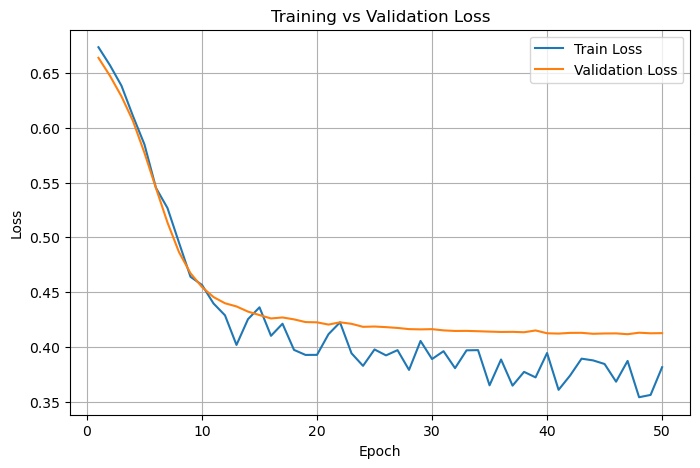

In [636]:
#Q6.6
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

#### 7. Final Evaluation on the Test Set

Use the code below to calculate the test accuracy and AUC score. Again, no code for you to add here!

In [637]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []   # for AUC (raw sigmoid outputs)
all_labels = []  # true labels

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch).squeeze()  # sigmoid probabilities
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * X_batch.size(0)

        # Store for AUC
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

        # Accuracy (thresholded at 0.5)
        preds = (outputs >= 0.5).float()
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

# Compute averages
avg_test_loss = test_loss / test_total
acc_nn = test_correct / test_total

# Compute AUC
auc_nn = roc_auc_score(all_labels, all_preds)

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {acc_nn:.4f}")
print(f"Test AUC: {auc_nn:.4f}")


Test Loss: 0.4138
Test Accuracy: 0.8324
Test AUC: 0.8681


# Q7 - Model Evaluation & Comparison

#### 1. Accuracy and AUC Comparison
Display the accuracy and AUC of each model in a table using the `display()` function.

In [639]:
#Q7.1
results = pd.DataFrame({
    "Model": ["Decision Tree", "XGBoost", "Neural Network"],
    "Accuracy": [acc_dt, acc_xgb, acc_nn],
    "AUC": [auc_dt, auc_xgb, auc_nn]
})

display(results)

,Model,Accuracy,AUC
0,Decision Tree,0.826816,0.856192
1,XGBoost,0.826816,0.805072
2,Neural Network,0.832402,0.868116


#### Discussion

State which model performed best. If you wanted to attempt to improve performance of any of these models' performance what would you try and what is the reasoning behind your decision?

Discussion answer here.

In [ ]:
The model that performed the best was the neural network. To improve performance, I would try improving the XGBoost model first, since boosted trees usually perform the best on tabular data like the Titanic dataset. I’d tweak things like the learning rate, number of trees, and tree depth. For the neural network, I would try slightly bigger or smaller hidden layers. This can potentially help reduce overfitting.